In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Deep learning librarie
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications.imagenet_utils import preprocess_input,decode_predictions

In [3]:
covid_train = "/kaggle/input/covid-shorten/covid19_shorten/covid19/Data/train/COVID19"
normal_train = "/kaggle/input/covid-shorten/covid19_shorten/covid19/Data/train/NORMAL"
pneumonia_train = "/kaggle/input/covid-shorten/covid19_shorten/covid19/Data/train/PNEUMONIA"
lung_opacity="/kaggle/input/covid-shorten/covid19_shorten/covid19/Data/train/LUNG_OPACITY"

len_covid_train = len(os.listdir(covid_train))
len_normal_train = len(os.listdir(normal_train))
len_pneumonia_train =  len(os.listdir(pneumonia_train))
len_lung_opacity= len(os.listdir(lung_opacity))

print("Number of covid Images:",len_covid_train)
print("Number of normal Images:",len_normal_train)
print("Number of pneumonia Images:",len_pneumonia_train)
print("Number of lung_opacity Images:",len_lung_opacity)
print("Total Number of Images:",len_covid_train+len_normal_train+len_pneumonia_train+len_lung_opacity)

Number of covid Images: 576
Number of normal Images: 1066
Number of pneumonia Images: 1013
Number of lung_opacity Images: 1052
Total Number of Images: 3707


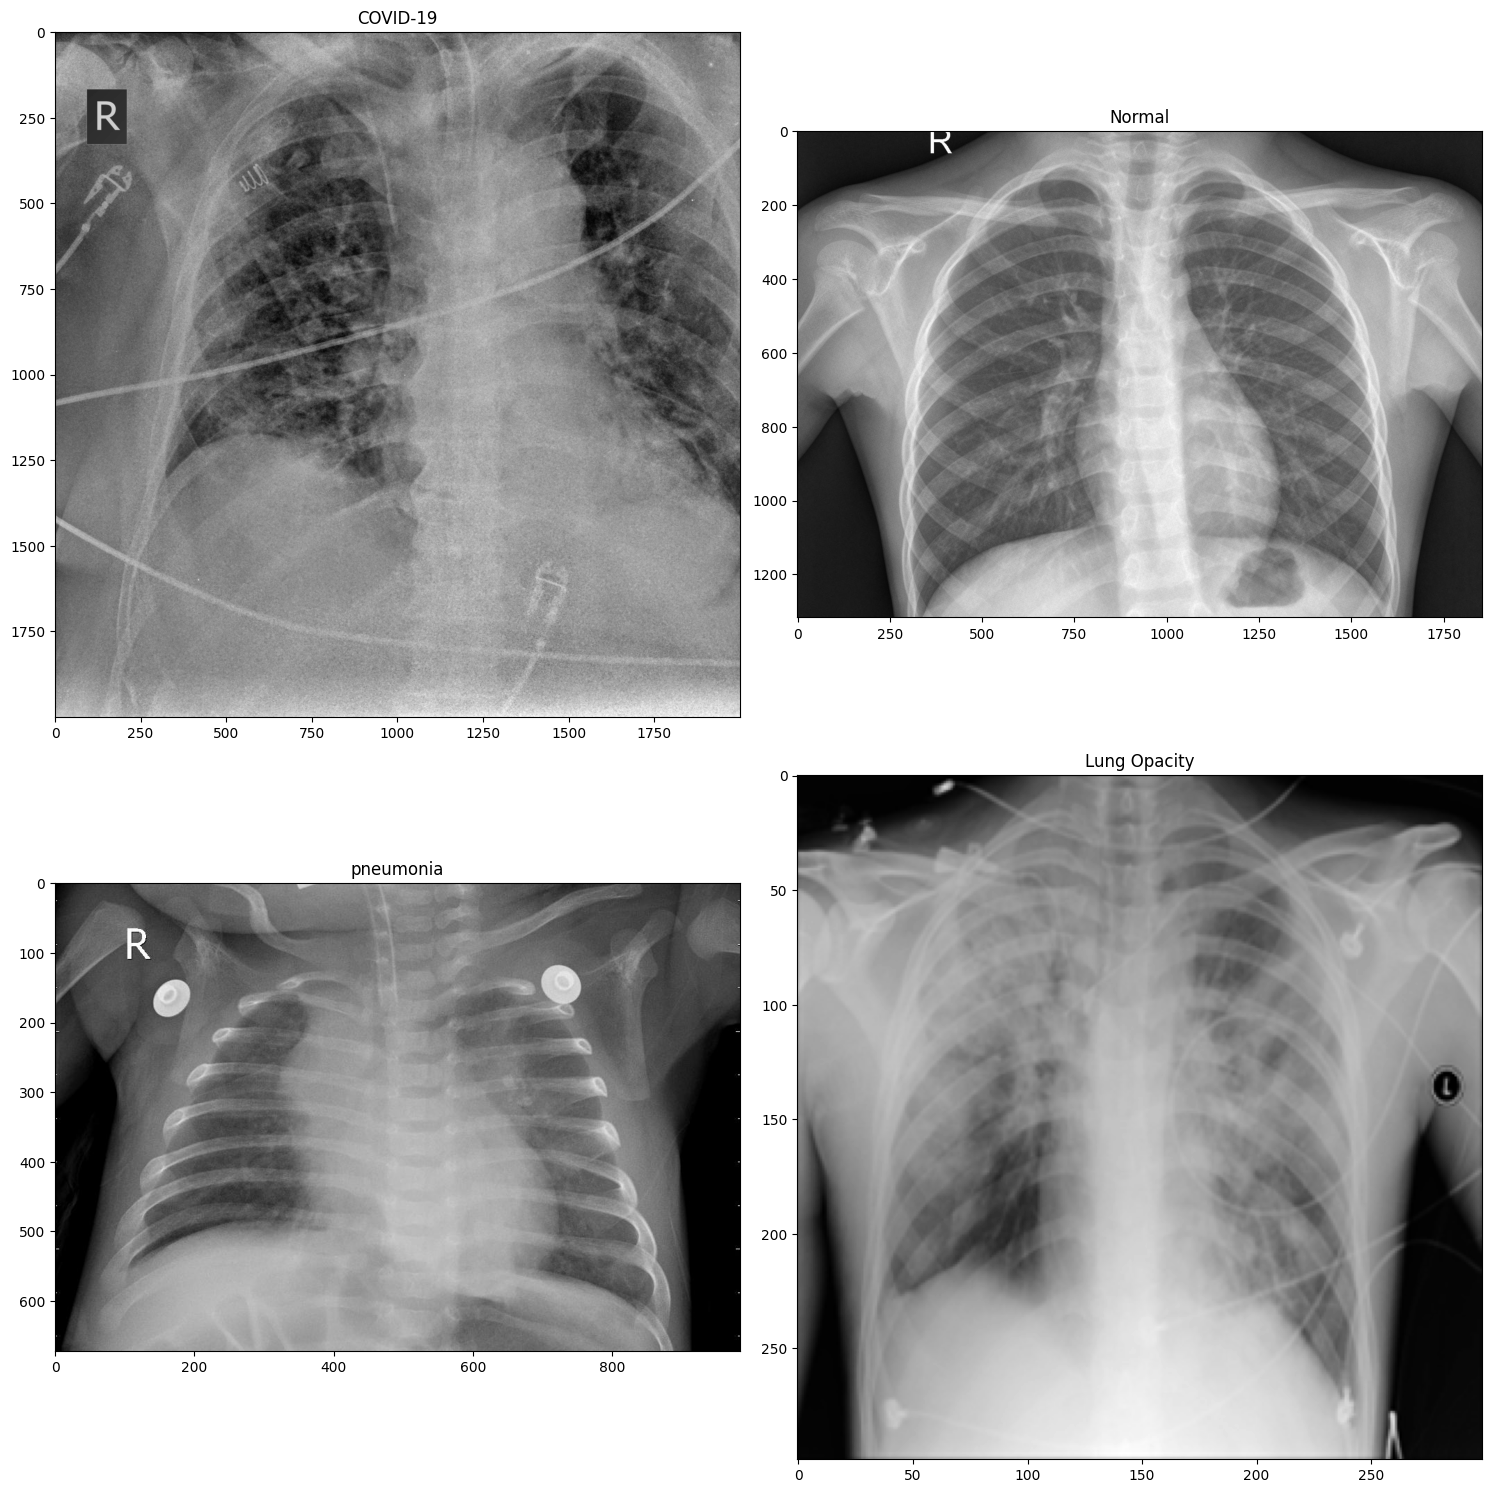

In [4]:
labels = ['COVID-19','Normal', 'pneumonia','Lung Opacity']
img1 = covid_train+"/COVID19(0).jpg"
img2 = normal_train+"/NORMAL(0).jpg"
img3 = pneumonia_train + "/PNEUMONIA(1054).jpg"
img4 = lung_opacity + "/Lung_Opacity-2010.png"

imgs = [img1, img2, img3,img4]

fig, ax = plt.subplots(2,2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,4):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

In [5]:
fpath = "/kaggle/input/covid-shorten/covid19_shorten/covid19/Data/train"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:4]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories)) 

List of categories =  ['PNEUMONIA', 'NORMAL', 'COVID19', 'LUNG_OPACITY'] 

No. of categories =  4


In [6]:
import os
import cv2
from PIL import Image
import numpy as np

def load_images_and_labels(categories, batch_size=32):
    img_lst = []
    labels = []
    for index, category in enumerate(categories):
        img_names = os.listdir(fpath+"/"+category)
        num_batches = len(img_names) // batch_size + int(len(img_names) % batch_size != 0)
        for i in range(num_batches):
            batch_names = img_names[i*batch_size:(i+1)*batch_size]
            batch_imgs = [cv2.imread(fpath+"/"+category+"/"+name) for name in batch_names]
            batch_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in batch_imgs]
            batch_imgs = [np.array(Image.fromarray(img).resize((224, 224))) for img in batch_imgs]
            img_lst.extend(batch_imgs)
            labels.extend([index]*len(batch_imgs))
    return img_lst, labels


In [7]:
images, labels = load_images_and_labels(categories)
print("Number of images: ", len(images))
print("Number of labels: ", len(labels))

Number of images:  3707
Number of labels:  3707


In [8]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (3707, 224, 224, 3) 
Labels shape =  (3707,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images, labels = shuffle(images, labels )
images.resize((images.shape[0],224,224,3))
#images = images.reshape((images.shape[0],1))

from keras.utils import to_categorical
label_output_matrix = to_categorical(labels, num_classes = 4, dtype ="int32")

x_train, x_test, y_train, y_test = train_test_split(images, label_output_matrix, test_size=0.2, random_state=24)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (2965, 224, 224, 3)
y_train shape =  (2965, 4)

x_test shape =  (742, 224, 224, 3)
y_test shape =  (742, 4)


In [10]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

In [11]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model = tf.keras.models.Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 47,028,548
Trainable params: 47,028,548
No

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 47,028,548
Trainable params: 47,028,548
No

In [15]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                            batch_size=32, epochs=10)

Epoch 1/10
93/93 [==============================] - 74s 580ms/step - loss: 3.9906 - accuracy: 0.5383 - val_loss: 0.8587 - val_accuracy: 0.6617
Epoch 2/10
93/93 [==============================] - 47s 503ms/step - loss: 0.7073 - accuracy: 0.7116 - val_loss: 0.6268 - val_accuracy: 0.7668
Epoch 3/10
93/93 [==============================] - 47s 501ms/step - loss: 0.5300 - accuracy: 0.7949 - val_loss: 0.5033 - val_accuracy: 0.8154
Epoch 4/10
93/93 [==============================] - 47s 501ms/step - loss: 0.4353 - accuracy: 0.8371 - val_loss: 0.3851 - val_accuracy: 0.8706
Epoch 5/10
93/93 [==============================] - 47s 501ms/step - loss: 0.3198 - accuracy: 0.8806 - val_loss: 0.4384 - val_accuracy: 0.8504
Epoch 6/10
93/93 [==============================] - 45s 480ms/step - loss: 0.3062 - accuracy: 0.8779 - val_loss: 0.3711 - val_accuracy: 0.8612
Epoch 7/10
93/93 [==============================] - 45s 481ms/step - loss: 0.3107 - accuracy: 0.8887 - val_loss: 0.3624 - val_accuracy: 0.8598

In [16]:
mypredict = model.predict(x_test)
pred = np.argmax(mypredict, axis=-1)
print(pred)
evalute = model.evaluate(x_test, y_test)
print("Accuracy: {:.2f}%".format(evalute[1] * 100))  
print("Loss: {}".format(evalute[0]))

24/24 [==============================] - 3s 134ms/step
[1 3 2 2 2 0 2 0 3 0 2 0 0 3 0 2 0 0 3 0 1 1 1 0 0 0 1 3 0 0 1 1 1 0 1 0 0
 0 1 1 0 0 2 1 2 1 3 1 0 3 1 3 1 3 0 3 0 0 2 1 3 0 3 1 3 3 3 2 0 2 0 3 0 1
 1 1 3 1 1 1 0 1 2 1 3 0 0 0 3 3 3 0 0 0 0 3 0 1 0 2 1 3 3 3 1 0 0 3 1 0 0
 3 3 0 0 0 3 1 3 1 1 0 1 0 0 3 1 3 3 0 1 0 1 1 0 3 0 3 1 0 0 3 1 3 2 1 1 0
 3 3 3 0 0 1 3 0 1 2 2 3 2 0 0 0 1 3 0 3 3 1 3 1 0 0 0 1 3 0 0 3 1 1 3 1 2
 3 2 2 3 0 3 3 2 3 1 0 3 0 3 3 0 1 3 3 0 2 0 2 1 0 2 2 1 1 1 1 2 3 3 2 0 0
 0 3 0 1 2 0 1 1 0 2 0 0 0 3 3 0 3 1 3 2 2 1 3 3 3 1 0 1 1 2 0 2 0 3 1 0 2
 0 0 3 0 0 1 3 2 0 3 1 3 3 0 0 3 3 3 0 0 1 2 3 0 1 3 2 3 0 0 1 0 3 3 1 2 0
 0 1 1 2 2 2 3 3 0 1 2 0 1 0 3 2 1 3 0 2 2 1 3 2 0 1 2 3 1 0 2 3 3 1 0 3 1
 0 1 1 2 3 3 0 0 0 3 1 2 0 2 2 1 0 1 3 1 2 1 3 3 3 3 3 0 3 2 0 0 0 0 3 3 3
 0 1 0 0 1 0 0 0 1 2 0 3 0 0 2 3 0 0 3 3 3 3 2 3 3 1 1 2 0 1 0 3 0 0 0 3 3
 0 2 2 1 3 0 0 0 0 1 3 0 0 1 3 1 0 3 1 2 1 0 3 0 3 1 0 3 0 1 1 3 1 1 0 0 3
 0 3 3 2 3 3 3 0 3 3 3 3 0 1 0 1 3 3 0 3 3 1 

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
x_output=model.predict(x_train)

93/93 [==============================] - 12s 135ms/step


In [19]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_output, y_train)
y_pred_rf = rf.predict(mypredict)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf)*100)
print("Random Forest Precision:", precision_score(y_test, y_pred_rf,average='micro')*100)
print("Random Forest Recall:", recall_score(y_test, y_pred_rf,average='micro')*100)
print("Random Forest F1-score:", f1_score(y_test, y_pred_rf,average='micro')*100)

rf_acc=accuracy_score(y_test, y_pred_rf)
rf_pre=precision_score(y_test, y_pred_rf,average='micro')
rf_rec=recall_score(y_test, y_pred_rf,average='micro')
rf_f1=f1_score(y_test, y_pred_rf,average='micro')

Random Forest Accuracy: 90.70080862533693
Random Forest Precision: 91.31614654002713
Random Forest Recall: 90.70080862533693
Random Forest F1-score: 91.00743745774172


In [20]:
#Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(x_output, y_train)
y_pred_dt = dt.predict(mypredict)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt)*100)
print("Decision Tree Precision:", precision_score(y_test, y_pred_dt,average='micro')*100)
print("Decision Tree Recall:", recall_score(y_test, y_pred_dt,average='micro')*100)
print("Decision Tree F1-score:", f1_score(y_test, y_pred_dt,average='micro')*100)

dt_acc=accuracy_score(y_test, y_pred_dt)
dt_pre=precision_score(y_test, y_pred_dt,average='micro')
dt_rec=recall_score(y_test, y_pred_dt,average='micro')
dt_f1=f1_score(y_test, y_pred_dt,average='micro')

Decision Tree Accuracy: 89.62264150943396
Decision Tree Precision: 89.62264150943396
Decision Tree Recall: 89.62264150943396
Decision Tree F1-score: 89.62264150943396


In [21]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_output, y_train)
y_pred_knn = knn.predict(mypredict)

print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn)*100)
print("K-Nearest Neighbors Precision:", precision_score(y_test, y_pred_knn, average='micro')*100)
print("K-Nearest Neighbors Recall:", recall_score(y_test, y_pred_knn, average='micro')*100)
print("K-Nearest Neighbors F1-score:", f1_score(y_test, y_pred_knn, average='micro')*100)

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_pre = precision_score(y_test, y_pred_knn, average='micro')
knn_rec = recall_score(y_test, y_pred_knn, average='micro')
knn_f1 = f1_score(y_test, y_pred_knn, average='micro')


K-Nearest Neighbors Accuracy: 92.45283018867924
K-Nearest Neighbors Precision: 92.45283018867924
K-Nearest Neighbors Recall: 92.45283018867924
K-Nearest Neighbors F1-score: 92.45283018867924


In [22]:
# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(x_output, y_train)
y_pred_etc = etc.predict(mypredict)

print("Extra Trees Classifier Accuracy:", accuracy_score(y_test, y_pred_etc)*100)
print("Extra Trees Classifier Precision:", precision_score(y_test, y_pred_etc, average='micro')*100)
print("Extra Trees Classifier Recall:", recall_score(y_test, y_pred_etc, average='micro')*100)
print("Extra Trees Classifier F1-score:", f1_score(y_test, y_pred_etc, average='micro')*100)

etc_acc = accuracy_score(y_test, y_pred_etc)
etc_pre = precision_score(y_test, y_pred_etc, average='micro')
etc_rec = recall_score(y_test, y_pred_etc, average='micro')
etc_f1 = f1_score(y_test, y_pred_etc, average='micro')


Extra Trees Classifier Accuracy: 90.29649595687331
Extra Trees Classifier Precision: 90.78590785907859
Extra Trees Classifier Recall: 90.29649595687331
Extra Trees Classifier F1-score: 90.54054054054055


In [25]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]

table.add_row(["Random Forest", rf_acc*100, rf_pre*100, rf_rec*100, rf_f1*100])
table.add_row(["Decision Tree", dt_acc*100, dt_pre*100, dt_rec*100, dt_f1*100])
table.add_row(["KNN", knn_acc*100, knn_pre*100, knn_rec*100, knn_f1*100])
table.add_row(["Extra Trees", etc_acc*100, etc_pre*100, etc_rec*100, etc_f1*100])

print(table)


+---------------+-------------------+-------------------+-------------------+-------------------+
|     Model     |      Accuracy     |     Precision     |       Recall      |      F1-score     |
+---------------+-------------------+-------------------+-------------------+-------------------+
| Random Forest | 90.70080862533693 | 91.31614654002713 | 90.70080862533693 | 91.00743745774172 |
| Decision Tree | 89.62264150943396 | 89.62264150943396 | 89.62264150943396 | 89.62264150943396 |
|      KNN      | 92.45283018867924 | 92.45283018867924 | 92.45283018867924 | 92.45283018867924 |
|  Extra Trees  | 90.29649595687331 | 90.78590785907859 | 90.29649595687331 | 90.54054054054055 |
+---------------+-------------------+-------------------+-------------------+-------------------+
